# 01 — Data Collection
## The Ship Index: Can shipping costs predict GDP?

This notebook pulls the two core datasets for our analysis:
1. **Baltic Dry Index (BDI)** — daily shipping cost index (2000–2025)
2. **GDP data** — quarterly real GDP for UK, US, and Eurozone from FRED

By the end of this notebook, we'll have clean CSV files saved in `data/raw/`.

---
## Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Data retrieval
from fredapi import Fred

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
plt.style.use('seaborn-v0_8-whitegrid')

print('All libraries loaded successfully!')

All libraries loaded successfully!


---
## 1. FRED API Setup

We need a free API key from FRED to pull GDP data.

**Get your key here:** https://fred.stlouisfed.org/docs/api/api_key.html

Paste it below (replace the placeholder):

In [2]:
# ⚠️ Replace with your actual FRED API key
FRED_API_KEY = 'aa7ce11c1934e626fd04cf49f12b9488'

fred = Fred(api_key=FRED_API_KEY)
print('FRED API connected successfully!')

FRED API connected successfully!


---
## 2. Pull GDP Data from FRED

We'll pull quarterly real GDP for three economies:
- **UK** — our primary focus (FRED series: `NGDPRSAXDCGBQ`)
- **US** — the world's largest economy (FRED series: `GDPC1`)
- **Eurozone** — major trading bloc (FRED series: `CLVMNACSCAB1GQEA19`)

This gives us a rich comparison: does the BDI predict trade-dependent economies better?

In [3]:
# Define the GDP series we want
gdp_series = {
    'uk_gdp': 'NGDPRSAXDCGBQ',      # UK Real GDP, quarterly, seasonally adjusted
    'us_gdp': 'GDPC1',               # US Real GDP, quarterly, seasonally adjusted
    'eurozone_gdp': 'CLVMNACSCAB1GQEA19'  # Eurozone Real GDP
}

# Set date range
start_date = '2000-01-01'
end_date = '2025-12-31'

# Pull each series
gdp_data = {}
for name, series_id in gdp_series.items():
    try:
        data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
        gdp_data[name] = data
        print(f'✓ {name} ({series_id}): {len(data)} observations from {data.index[0].strftime("%Y-%m-%d")} to {data.index[-1].strftime("%Y-%m-%d")}')
    except Exception as e:
        print(f'✗ {name} ({series_id}): Error — {e}')

✓ uk_gdp (NGDPRSAXDCGBQ): 104 observations from 2000-01-01 to 2025-10-01
✓ us_gdp (GDPC1): 104 observations from 2000-01-01 to 2025-10-01
✓ eurozone_gdp (CLVMNACSCAB1GQEA19): 104 observations from 2000-01-01 to 2025-10-01


In [11]:
# Combine into a single DataFrame
gdp_df = pd.DataFrame(gdp_data)
gdp_df.index.name = 'date'

print(f'\nGDP DataFrame shape: {gdp_df.shape}')
print(f'Date range: {gdp_df.index[0]} to {gdp_df.index[-1]}')
print(f'\nFirst few rows:')
gdp_df.head()


GDP DataFrame shape: (104, 3)
Date range: 2000-01-01 00:00:00 to 2025-10-01 00:00:00

First few rows:


,uk_gdp,us_gdp,eurozone_gdp
date,,,
2000-01-01,480212.0,13878.147,2108727.5
2000-04-01,483672.0,14130.908,2127946.8
2000-07-01,486617.0,14145.312,2142209.2
2000-10-01,489506.0,14229.765,2152418.5
2001-01-01,493575.0,14183.120,2176141.6


In [12]:
# Check for missing values
print('Missing values per column:')
print(gdp_df.isnull().sum())
print(f'\nTotal rows: {len(gdp_df)}')

Missing values per column:
uk_gdp          0
us_gdp          0
eurozone_gdp    0
dtype: int64

Total rows: 104


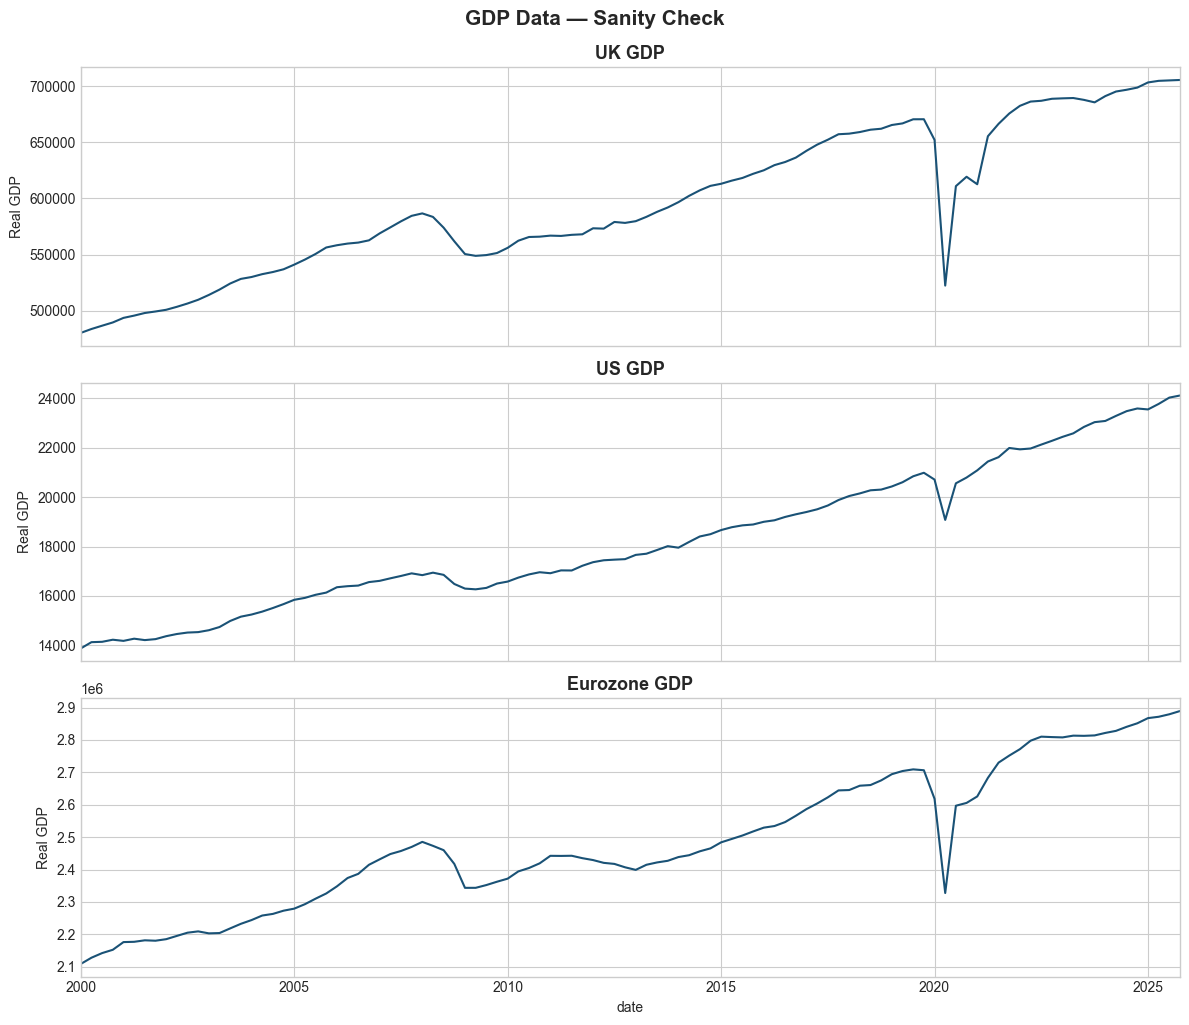

If you can see three upward-trending lines with a dip around 2008 and 2020, the data looks correct!


In [13]:
# Quick sanity check — plot all three GDP series
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for ax, (name, label) in zip(axes, [('uk_gdp', 'UK GDP'), ('us_gdp', 'US GDP'), ('eurozone_gdp', 'Eurozone GDP')]):
    gdp_df[name].dropna().plot(ax=ax, color='#1A5276', linewidth=1.5)
    ax.set_title(label, fontsize=13, fontweight='bold')
    ax.set_ylabel('Real GDP')

plt.tight_layout()
plt.suptitle('GDP Data — Sanity Check', fontsize=15, fontweight='bold', y=1.02)
plt.show()

print('If you can see three upward-trending lines with a dip around 2008 and 2020, the data looks correct!')

---
## 3. Load Baltic Dry Index Data

The BDI isn't available through a free API, so we need to download it manually as a CSV.

### How to get the data:

**Option A — Investing.com (recommended):**
1. Go to https://www.investing.com/indices/baltic-dry-historical-data
2. Set the date range to 01/01/2000 — today
3. Click "Download Data" (you may need to create a free account)
4. Save the CSV file to your `data/raw/` folder as `bdi_raw.csv`

**Option B — Trading Economics:**
1. Go to https://tradingeconomics.com/commodity/baltic
2. Export the historical data
3. Save to `data/raw/bdi_raw.csv`

Once you've saved the file, run the cell below to load it.

In [14]:
# Load the BDI CSV
# NOTE: You may need to adjust the column names depending on your source
# Common formats:
#   Investing.com: columns are 'Date', 'Price', 'Open', 'High', 'Low', 'Change %'
#   Trading Economics: may differ

bdi_path = '../data/raw/bdi_raw.csv'

try:
    bdi_raw = pd.read_csv(bdi_path)
    print(f'✓ BDI data loaded: {len(bdi_raw)} rows')
    print(f'\nColumns found: {list(bdi_raw.columns)}')
    print(f'\nFirst few rows:')
    display(bdi_raw.head())
except FileNotFoundError:
    print(f'✗ File not found at {bdi_path}')
    print('\nPlease download the BDI data following the instructions above.')
    print('Save it as: data/raw/bdi_raw.csv')

✓ BDI data loaded: 5000 rows

Columns found: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First few rows:


,Date,Price,Open,High,Low,Vol.,Change %
0,01/04/2000,"1,320.00","1,320.00","1,320.00","1,320.00",NaN,0.08%
1,01/05/2000,"1,329.00","1,329.00","1,329.00","1,329.00",NaN,0.68%
2,01/06/2000,"1,351.00","1,351.00","1,351.00","1,351.00",NaN,1.66%
3,01/07/2000,"1,368.00","1,368.00","1,368.00","1,368.00",NaN,1.26%
4,01/10/2000,"1,376.00","1,376.00","1,376.00","1,376.00",NaN,0.58%


In [15]:
# Parse and clean the BDI data
# ⚠️ ADJUST THIS SECTION based on your CSV's column names

# --- For Investing.com format ---
# The 'Price' column often has commas (e.g. '11,793') and dates are in 'MM/DD/YYYY' format

bdi_df = bdi_raw.copy()

# Rename columns to standard names (adjust if your columns differ)
# Common Investing.com columns: 'Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'
if 'Price' in bdi_df.columns:
    # Investing.com format
    bdi_df['date'] = pd.to_datetime(bdi_df['Date'])
    
    # Remove commas from price and convert to float
    bdi_df['bdi_close'] = bdi_df['Price'].astype(str).str.replace(',', '').astype(float)
    
    bdi_df = bdi_df[['date', 'bdi_close']].sort_values('date').reset_index(drop=True)
    
elif 'DateTime' in bdi_df.columns:
    # Trading Economics format
    bdi_df['date'] = pd.to_datetime(bdi_df['DateTime'])
    bdi_df['bdi_close'] = bdi_df['Value'].astype(float)
    bdi_df = bdi_df[['date', 'bdi_close']].sort_values('date').reset_index(drop=True)

else:
    print('⚠️ Unrecognised CSV format. Columns found:', list(bdi_df.columns))
    print('Please adjust the parsing code above to match your file.')

# Set date as index
bdi_df = bdi_df.set_index('date')

print(f'\n✓ BDI data parsed successfully')
print(f'  Shape: {bdi_df.shape}')
print(f'  Date range: {bdi_df.index[0].strftime("%Y-%m-%d")} to {bdi_df.index[-1].strftime("%Y-%m-%d")}')
print(f'  BDI range: {bdi_df["bdi_close"].min():.0f} to {bdi_df["bdi_close"].max():.0f}')
print(f'  Missing values: {bdi_df["bdi_close"].isnull().sum()}')
bdi_df.head()


✓ BDI data parsed successfully
  Shape: (5000, 1)
  Date range: 2000-01-04 to 2020-01-06
  BDI range: 290 to 11793
  Missing values: 0


,bdi_close
date,
2000-01-04,1320.0
2000-01-05,1329.0
2000-01-06,1351.0
2000-01-07,1368.0
2000-01-10,1376.0


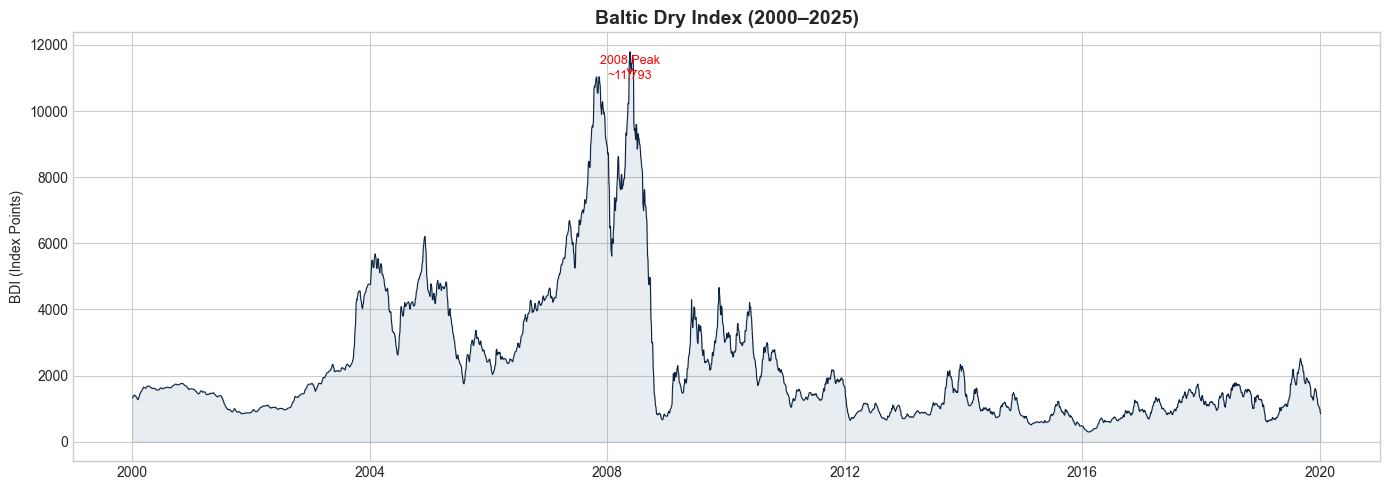

You should see a massive spike around 2008 followed by a crash — that's correct!
The BDI peaked at ~11,793 in May 2008, then collapsed to ~663 by December 2008.


In [16]:
# Quick sanity check — plot the BDI
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(bdi_df.index, bdi_df['bdi_close'], color='#0C2340', linewidth=0.8)
ax.fill_between(bdi_df.index, bdi_df['bdi_close'], alpha=0.1, color='#1A5276')
ax.set_title('Baltic Dry Index (2000–2025)', fontsize=14, fontweight='bold')
ax.set_ylabel('BDI (Index Points)')
ax.set_xlabel('')

# Annotate the famous 2008 peak and crash
ax.annotate('2008 Peak\n~11,793', xy=(pd.Timestamp('2008-05-20'), 11000),
            fontsize=9, ha='center', color='red',
            arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

print('You should see a massive spike around 2008 followed by a crash — that\'s correct!')
print('The BDI peaked at ~11,793 in May 2008, then collapsed to ~663 by December 2008.')

---
## 4. Save Raw Data

Let's save our cleaned raw data to `data/raw/` so we have a consistent starting point.

In [17]:
# Create output directory if it doesn't exist
os.makedirs('../data/raw', exist_ok=True)

# Save GDP data
gdp_df.to_csv('../data/raw/gdp_quarterly.csv')
print(f'✓ GDP data saved to data/raw/gdp_quarterly.csv ({len(gdp_df)} rows)')

# Save cleaned BDI data
bdi_df.to_csv('../data/raw/bdi_daily.csv')
print(f'✓ BDI data saved to data/raw/bdi_daily.csv ({len(bdi_df)} rows)')

✓ GDP data saved to data/raw/gdp_quarterly.csv (104 rows)
✓ BDI data saved to data/raw/bdi_daily.csv (5000 rows)


---
## 5. Quick Summary Stats

Before we finish, let's get a high-level view of both datasets.

In [18]:
print('='*60)
print('BALTIC DRY INDEX — Summary')
print('='*60)
print(f'Period:     {bdi_df.index[0].strftime("%B %Y")} to {bdi_df.index[-1].strftime("%B %Y")}')
print(f'Data points: {len(bdi_df):,}')
print(f'Mean:       {bdi_df["bdi_close"].mean():,.0f}')
print(f'Median:     {bdi_df["bdi_close"].median():,.0f}')
print(f'Min:        {bdi_df["bdi_close"].min():,.0f} ({bdi_df["bdi_close"].idxmin().strftime("%Y-%m-%d")})')
print(f'Max:        {bdi_df["bdi_close"].max():,.0f} ({bdi_df["bdi_close"].idxmax().strftime("%Y-%m-%d")})')
print()
print('='*60)
print('GDP DATA — Summary')
print('='*60)
for col in gdp_df.columns:
    series = gdp_df[col].dropna()
    print(f'\n{col}:')
    print(f'  Period:      {series.index[0].strftime("%B %Y")} to {series.index[-1].strftime("%B %Y")}')
    print(f'  Data points: {len(series)}')
    print(f'  Latest value: {series.iloc[-1]:,.2f}')

BALTIC DRY INDEX — Summary
Period:     January 2000 to January 2020
Data points: 5,000
Mean:       2,326
Median:     1,546
Min:        290 (2016-02-10)
Max:        11,793 (2008-05-20)

GDP DATA — Summary

uk_gdp:
  Period:      January 2000 to October 2025
  Data points: 104
  Latest value: 705,571.00

us_gdp:
  Period:      January 2000 to October 2025
  Data points: 104
  Latest value: 24,111.83

eurozone_gdp:
  Period:      January 2000 to October 2025
  Data points: 104
  Latest value: 2,889,150.00


---
## ✅ Phase 1 Complete!

**What we've accomplished:**
- Pulled 25 years of GDP data for UK, US, and Eurozone from FRED
- Loaded and parsed the Baltic Dry Index historical data
- Verified both datasets with sanity check visualisations
- Saved clean raw data to `data/raw/`

**Next up — Phase 2: Data Cleaning & EDA**
- Aggregate daily BDI to quarterly frequency
- Calculate growth rates for both BDI and GDP
- Create the hero dual-axis overlay chart
- Annotate major economic events

Don't forget to commit your work!
```
git add .
git commit -m "Phase 1: Data collection complete — BDI and GDP data pulled"
git push
```